#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Define paths

In [2]:
train_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '1000', 'train')
val_image_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'image_data', 'small', '1000', 'val')
train_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '1000', 'train')
val_labels_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'labels', 'small', '1000', 'val')
load_models_path = os.path.join('/home', 'renat_sergazinov', 'python-git-workspace', 
                               'PhotoForceReconML', 'models')
save_models_path = os.path.join('/home', 'renat_sergazinov', 
                          'python-git-workspace', 'PhotoForceReconML', 'models', 'small', '1000')

#### Data preprocessing and augmentation

Load the data from the directory. The data are the images of particles split into subdirectories based on the number of forces acting on the particle. The labels should be loaded from a separate directory. Each label corresponds to two particles. 

The size of all images is adjusted so that all images are 128*128 using nearest neighbor interpolation. Validation split is performed: 20% is set aside for validation. Additionally images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1].

In [3]:
# Define sorter of image names in order by image number (default is alphanumric)
def sorter(item):
    # Since highest marks first, least error = most marks
    radius = float(item[1 : item.find('_')])
    num_img = int(item[item.find('g') + 1 : item.find('j') - 1])
    return (radius, num_img)

In [4]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(train_image_path, str(i))
    X_path_val = os.path.join(val_image_path, str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(train_labels_path, str(i), 'angles_inner.npy'))
    y_val[i] = np.load(os.path.join(val_labels_path, str(i), 'angles_inner.npy'))

In [5]:
# Define class for data generation
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_image_paths = None, labels = None,  
                 batch_size = 32, dim = None, n_channels = 3, rescale = 1, 
                 shuffle=True, save_dir = None, preprocessing_func = None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_image_paths = list_image_paths
        self.n_channels = n_channels
        self.rescale = rescale
        self.shuffle = shuffle
        self.save_dir = save_dir
        self.preprocessing_func = preprocessing_func
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indices)
        
        if self.save_dir is not None:
            for i in range(X.shape[0]):
                path = os.path.join(self.save_dir, 'img' + str(i) + '.jpg')
                plt.imsave(path, np.asarray(X[i, ]), vmin = 0, vmax = 1)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.list_image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialisation
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        list_image_paths_batch = [self.list_image_paths[k] for k in indices]
        
        # Get labels
        y = np.array([self.labels[k, :] for k in indices])
        
        # Generate data
        for i, image_path in enumerate(list_image_paths_batch):
            # Load image and transform
            image = Image.open(os.path.join(image_path))
            if self.dim is not None:
                image = image.resize(self.dim, resample = Image.NEAREST)
            image = np.array(image)[:, :, :self.n_channels]
            image = image * self.rescale
            if self.preprocessing_func is not None:
                image = self.preprocessing_func(image)
            # Store sample
            X[i,] = image

        return X, y

In [6]:
# Define gaussian blur class
class GaussBlur:
    def __init__(self, radius):
        self.radius = radius
    def blur(self, image):
        return gaussian_filter(image, sigma = self.radius)

In [7]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGenerator(X_val[i], y_val[i], **params) 

#### VGG19 Models Training

Convolutional neural networks is defined and compiled in this step.

In [8]:
models_ai = dict()                         
for k in range(5):
     i = k + 2
     models_ai[i] = load_model(os.path.join(load_models_path, 'vgg19_angles_inner_'+str(i)+'.h5'))

In [9]:
for k in range(5):
    i = k + 2
    models_ai[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 28,416,066
Trainable params: 28,416,066
Non-trainable params: 0
_________________________________________________

In [10]:
for k in range(5):
    i = 2 + k
    models_ai[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-7),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = dict()
for k in range(5):
    i = k + 2
    model_path = os.path.join(save_models_path, 'vgg19_angles_inner_'+str(i)+'.h5')
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

epochs = 1000
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = models_ai[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/1000
25/25 [==============================] - ETA: 0s - loss: 0.1479 - mean_absolute_error: 0.1479
Epoch 00001: val_loss improved from inf to 0.04044, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/1000/vgg19_angles_inner_2.h5
25/25 [==============================] - 3s 138ms/step - loss: 0.1479 - mean_absolute_error: 0.1479 - val_loss: 0.0404 - val_mean_absolute_error: 0.0404
Epoch 2/1000
25/25 [==============================] - ETA: 0s - loss: 0.1398 - mean_absolute_error: 0.1398
Epoch 00002: val_loss did not improve from 0.04044
25/25 [==============================] - 3s 114ms/step - loss: 0.1398 - mean_absolute_error: 0.1398 - val_loss: 0.0435 - val_mean_absolute_error: 0.0435
Epoch 3/1000
25/25 [==============================] - ETA: 0s - loss: 0.1407 - mean_absolute_error: 0.1407
Epoch 00003: val_loss did not improve from 0.04044
25/25 [==============================] - 3s 113ms/step - loss: 0.1407 - mean_a

Epoch 26/1000
25/25 [==============================] - ETA: 0s - loss: 0.1395 - mean_absolute_error: 0.1395
Epoch 00026: val_loss did not improve from 0.02414
25/25 [==============================] - 3s 110ms/step - loss: 0.1395 - mean_absolute_error: 0.1395 - val_loss: 0.0475 - val_mean_absolute_error: 0.0475
Epoch 27/1000
25/25 [==============================] - ETA: 0s - loss: 0.1386 - mean_absolute_error: 0.1386
Epoch 00027: val_loss did not improve from 0.02414
25/25 [==============================] - 3s 114ms/step - loss: 0.1386 - mean_absolute_error: 0.1386 - val_loss: 0.0411 - val_mean_absolute_error: 0.0411
Epoch 28/1000
25/25 [==============================] - ETA: 0s - loss: 0.1395 - mean_absolute_error: 0.1395
Epoch 00028: val_loss did not improve from 0.02414
25/25 [==============================] - 3s 111ms/step - loss: 0.1395 - mean_absolute_error: 0.1395 - val_loss: 0.0355 - val_mean_absolute_error: 0.0355
Epoch 29/1000
25/25 [==============================] - ETA: 0s -

25/25 [==============================] - ETA: 0s - loss: 0.1444 - mean_absolute_error: 0.1444
Epoch 00052: val_loss did not improve from 0.02414
25/25 [==============================] - 3s 111ms/step - loss: 0.1444 - mean_absolute_error: 0.1444 - val_loss: 0.0419 - val_mean_absolute_error: 0.0419
Epoch 53/1000
25/25 [==============================] - ETA: 0s - loss: 0.1413 - mean_absolute_error: 0.1413
Epoch 00053: val_loss did not improve from 0.02414
25/25 [==============================] - 3s 114ms/step - loss: 0.1413 - mean_absolute_error: 0.1413 - val_loss: 0.0324 - val_mean_absolute_error: 0.0324
Epoch 54/1000
25/25 [==============================] - ETA: 0s - loss: 0.1441 - mean_absolute_error: 0.1441
Epoch 00054: val_loss did not improve from 0.02414
25/25 [==============================] - 3s 112ms/step - loss: 0.1441 - mean_absolute_error: 0.1441 - val_loss: 0.0341 - val_mean_absolute_error: 0.0341
Epoch 55/1000
25/25 [==============================] - ETA: 0s - loss: 0.1415 

Epoch 10/1000
25/25 [==============================] - ETA: 0s - loss: 0.1390 - mean_absolute_error: 0.1390
Epoch 00010: val_loss did not improve from 0.09246
25/25 [==============================] - 3s 112ms/step - loss: 0.1390 - mean_absolute_error: 0.1390 - val_loss: 0.0934 - val_mean_absolute_error: 0.0934
Epoch 11/1000
25/25 [==============================] - ETA: 0s - loss: 0.1370 - mean_absolute_error: 0.1370
Epoch 00011: val_loss improved from 0.09246 to 0.08809, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/1000/vgg19_angles_inner_3.h5
25/25 [==============================] - 3s 130ms/step - loss: 0.1370 - mean_absolute_error: 0.1370 - val_loss: 0.0881 - val_mean_absolute_error: 0.0881
Epoch 12/1000
25/25 [==============================] - ETA: 0s - loss: 0.1380 - mean_absolute_error: 0.1380
Epoch 00012: val_loss did not improve from 0.08809
25/25 [==============================] - 3s 111ms/step - loss: 0.1380 - mean_absolute_error:

Epoch 35/1000
25/25 [==============================] - ETA: 0s - loss: 0.1312 - mean_absolute_error: 0.1312
Epoch 00035: val_loss did not improve from 0.07359
25/25 [==============================] - 3s 113ms/step - loss: 0.1312 - mean_absolute_error: 0.1312 - val_loss: 0.1069 - val_mean_absolute_error: 0.1069
Epoch 36/1000
25/25 [==============================] - ETA: 0s - loss: 0.1349 - mean_absolute_error: 0.1349
Epoch 00036: val_loss did not improve from 0.07359
25/25 [==============================] - 3s 110ms/step - loss: 0.1349 - mean_absolute_error: 0.1349 - val_loss: 0.1006 - val_mean_absolute_error: 0.1006
Epoch 37/1000
25/25 [==============================] - ETA: 0s - loss: 0.1338 - mean_absolute_error: 0.1338
Epoch 00037: val_loss did not improve from 0.07359
25/25 [==============================] - 3s 110ms/step - loss: 0.1338 - mean_absolute_error: 0.1338 - val_loss: 0.0967 - val_mean_absolute_error: 0.0967
Epoch 38/1000
25/25 [==============================] - ETA: 0s -

25/25 [==============================] - ETA: 0s - loss: 0.1342 - mean_absolute_error: 0.1342
Epoch 00061: val_loss did not improve from 0.07359
25/25 [==============================] - 3s 109ms/step - loss: 0.1342 - mean_absolute_error: 0.1342 - val_loss: 0.0987 - val_mean_absolute_error: 0.0987
Epoch 62/1000
25/25 [==============================] - ETA: 0s - loss: 0.1331 - mean_absolute_error: 0.1331
Epoch 00062: val_loss did not improve from 0.07359
25/25 [==============================] - 3s 115ms/step - loss: 0.1331 - mean_absolute_error: 0.1331 - val_loss: 0.0896 - val_mean_absolute_error: 0.0896
Epoch 63/1000
25/25 [==============================] - ETA: 0s - loss: 0.1341 - mean_absolute_error: 0.1341
Epoch 00063: val_loss did not improve from 0.07359
25/25 [==============================] - 3s 110ms/step - loss: 0.1341 - mean_absolute_error: 0.1341 - val_loss: 0.0997 - val_mean_absolute_error: 0.0997
Epoch 64/1000
25/25 [==============================] - ETA: 0s - loss: 0.1340 

Epoch 14/1000
25/25 [==============================] - ETA: 0s - loss: 0.1121 - mean_absolute_error: 0.1121
Epoch 00014: val_loss did not improve from 0.08385
25/25 [==============================] - 3s 111ms/step - loss: 0.1121 - mean_absolute_error: 0.1121 - val_loss: 0.0898 - val_mean_absolute_error: 0.0898
Epoch 15/1000
25/25 [==============================] - ETA: 0s - loss: 0.1154 - mean_absolute_error: 0.1154
Epoch 00015: val_loss did not improve from 0.08385
25/25 [==============================] - 3s 111ms/step - loss: 0.1154 - mean_absolute_error: 0.1154 - val_loss: 0.0987 - val_mean_absolute_error: 0.0987
Epoch 16/1000
25/25 [==============================] - ETA: 0s - loss: 0.1147 - mean_absolute_error: 0.1147
Epoch 00016: val_loss did not improve from 0.08385
25/25 [==============================] - 3s 111ms/step - loss: 0.1147 - mean_absolute_error: 0.1147 - val_loss: 0.0964 - val_mean_absolute_error: 0.0964
Epoch 17/1000
25/25 [==============================] - ETA: 0s -

Epoch 40/1000
25/25 [==============================] - ETA: 0s - loss: 0.1083 - mean_absolute_error: 0.1083
Epoch 00040: val_loss did not improve from 0.07755
25/25 [==============================] - 3s 116ms/step - loss: 0.1083 - mean_absolute_error: 0.1083 - val_loss: 0.0939 - val_mean_absolute_error: 0.0939
Epoch 41/1000
25/25 [==============================] - ETA: 0s - loss: 0.1016 - mean_absolute_error: 0.1016
Epoch 00041: val_loss did not improve from 0.07755
25/25 [==============================] - 3s 116ms/step - loss: 0.1016 - mean_absolute_error: 0.1016 - val_loss: 0.0893 - val_mean_absolute_error: 0.0893
Epoch 42/1000
25/25 [==============================] - ETA: 0s - loss: 0.1104 - mean_absolute_error: 0.1104
Epoch 00042: val_loss did not improve from 0.07755
25/25 [==============================] - 3s 111ms/step - loss: 0.1104 - mean_absolute_error: 0.1104 - val_loss: 0.0910 - val_mean_absolute_error: 0.0910
Epoch 43/1000
25/25 [==============================] - ETA: 0s -

Epoch 66/1000
25/25 [==============================] - ETA: 0s - loss: 0.1078 - mean_absolute_error: 0.1078
Epoch 00066: val_loss did not improve from 0.07604
25/25 [==============================] - 3s 111ms/step - loss: 0.1078 - mean_absolute_error: 0.1078 - val_loss: 0.0946 - val_mean_absolute_error: 0.0946
Epoch 67/1000
25/25 [==============================] - ETA: 0s - loss: 0.1089 - mean_absolute_error: 0.1089
Epoch 00067: val_loss did not improve from 0.07604
25/25 [==============================] - 3s 112ms/step - loss: 0.1089 - mean_absolute_error: 0.1089 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 68/1000
25/25 [==============================] - ETA: 0s - loss: 0.1087 - mean_absolute_error: 0.1087
Epoch 00068: val_loss did not improve from 0.07604
25/25 [==============================] - 3s 111ms/step - loss: 0.1087 - mean_absolute_error: 0.1087 - val_loss: 0.0945 - val_mean_absolute_error: 0.0945
Epoch 69/1000
25/25 [==============================] - ETA: 0s -

Epoch 92/1000
25/25 [==============================] - ETA: 0s - loss: 0.1092 - mean_absolute_error: 0.1092
Epoch 00092: val_loss did not improve from 0.06795
25/25 [==============================] - 3s 111ms/step - loss: 0.1092 - mean_absolute_error: 0.1092 - val_loss: 0.0820 - val_mean_absolute_error: 0.0820
Epoch 93/1000
25/25 [==============================] - ETA: 0s - loss: 0.1075 - mean_absolute_error: 0.1075
Epoch 00093: val_loss did not improve from 0.06795
25/25 [==============================] - 3s 111ms/step - loss: 0.1075 - mean_absolute_error: 0.1075 - val_loss: 0.0900 - val_mean_absolute_error: 0.0900
Epoch 94/1000
25/25 [==============================] - ETA: 0s - loss: 0.1103 - mean_absolute_error: 0.1103
Epoch 00094: val_loss did not improve from 0.06795
25/25 [==============================] - 3s 112ms/step - loss: 0.1103 - mean_absolute_error: 0.1103 - val_loss: 0.0972 - val_mean_absolute_error: 0.0972
Epoch 95/1000
25/25 [==============================] - ETA: 0s -

25/25 [==============================] - ETA: 0s - loss: 0.1080 - mean_absolute_error: 0.1080
Epoch 00118: val_loss did not improve from 0.06795
25/25 [==============================] - 3s 113ms/step - loss: 0.1080 - mean_absolute_error: 0.1080 - val_loss: 0.0865 - val_mean_absolute_error: 0.0865
Epoch 119/1000
25/25 [==============================] - ETA: 0s - loss: 0.1074 - mean_absolute_error: 0.1074
Epoch 00119: val_loss did not improve from 0.06795
25/25 [==============================] - 3s 110ms/step - loss: 0.1074 - mean_absolute_error: 0.1074 - val_loss: 0.0917 - val_mean_absolute_error: 0.0917
Epoch 00119: early stopping
Model for  5  angles
Epoch 1/1000
25/25 [==============================] - ETA: 0s - loss: 0.1727 - mean_absolute_error: 0.1727
Epoch 00001: val_loss improved from inf to 0.12545, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/1000/vgg19_angles_inner_5.h5
25/25 [==============================] - 3s 133ms/step - loss

Epoch 23/1000
25/25 [==============================] - ETA: 0s - loss: 0.1038 - mean_absolute_error: 0.1038
Epoch 00023: val_loss did not improve from 0.09051
25/25 [==============================] - 3s 112ms/step - loss: 0.1038 - mean_absolute_error: 0.1038 - val_loss: 0.0930 - val_mean_absolute_error: 0.0930
Epoch 24/1000
25/25 [==============================] - ETA: 0s - loss: 0.1014 - mean_absolute_error: 0.1014
Epoch 00024: val_loss did not improve from 0.09051
25/25 [==============================] - 3s 114ms/step - loss: 0.1014 - mean_absolute_error: 0.1014 - val_loss: 0.1034 - val_mean_absolute_error: 0.1034
Epoch 25/1000
25/25 [==============================] - ETA: 0s - loss: 0.1036 - mean_absolute_error: 0.1036
Epoch 00025: val_loss did not improve from 0.09051
25/25 [==============================] - 3s 113ms/step - loss: 0.1036 - mean_absolute_error: 0.1036 - val_loss: 0.1001 - val_mean_absolute_error: 0.1001
Epoch 26/1000
25/25 [==============================] - ETA: 0s -

25/25 [==============================] - ETA: 0s - loss: 0.1066 - mean_absolute_error: 0.1066
Epoch 00048: val_loss did not improve from 0.07256
25/25 [==============================] - 3s 112ms/step - loss: 0.1066 - mean_absolute_error: 0.1066 - val_loss: 0.0957 - val_mean_absolute_error: 0.0957
Epoch 49/1000
25/25 [==============================] - ETA: 0s - loss: 0.1037 - mean_absolute_error: 0.1037
Epoch 00049: val_loss did not improve from 0.07256
25/25 [==============================] - 3s 112ms/step - loss: 0.1037 - mean_absolute_error: 0.1037 - val_loss: 0.1018 - val_mean_absolute_error: 0.1018
Epoch 50/1000
25/25 [==============================] - ETA: 0s - loss: 0.1008 - mean_absolute_error: 0.1008
Epoch 00050: val_loss did not improve from 0.07256
25/25 [==============================] - 3s 111ms/step - loss: 0.1008 - mean_absolute_error: 0.1008 - val_loss: 0.0964 - val_mean_absolute_error: 0.0964
Epoch 51/1000
25/25 [==============================] - ETA: 0s - loss: 0.1005 

25/25 [==============================] - ETA: 0s - loss: 0.1000 - mean_absolute_error: 0.1000
Epoch 00074: val_loss did not improve from 0.07256
25/25 [==============================] - 3s 110ms/step - loss: 0.1000 - mean_absolute_error: 0.1000 - val_loss: 0.0867 - val_mean_absolute_error: 0.0867
Epoch 75/1000
25/25 [==============================] - ETA: 0s - loss: 0.0997 - mean_absolute_error: 0.0997
Epoch 00075: val_loss did not improve from 0.07256
25/25 [==============================] - 3s 111ms/step - loss: 0.0997 - mean_absolute_error: 0.0997 - val_loss: 0.0967 - val_mean_absolute_error: 0.0967
Epoch 76/1000
25/25 [==============================] - ETA: 0s - loss: 0.0992 - mean_absolute_error: 0.0992
Epoch 00076: val_loss did not improve from 0.07256
25/25 [==============================] - 3s 111ms/step - loss: 0.0992 - mean_absolute_error: 0.0992 - val_loss: 0.1002 - val_mean_absolute_error: 0.1002
Epoch 77/1000
25/25 [==============================] - ETA: 0s - loss: 0.1033 

25/25 [==============================] - ETA: 0s - loss: 0.1068 - mean_absolute_error: 0.1068
Epoch 00007: val_loss did not improve from 0.10469
25/25 [==============================] - 3s 110ms/step - loss: 0.1068 - mean_absolute_error: 0.1068 - val_loss: 0.1080 - val_mean_absolute_error: 0.1080
Epoch 8/1000
25/25 [==============================] - ETA: 0s - loss: 0.1063 - mean_absolute_error: 0.1063
Epoch 00008: val_loss did not improve from 0.10469
25/25 [==============================] - 3s 111ms/step - loss: 0.1063 - mean_absolute_error: 0.1063 - val_loss: 0.1065 - val_mean_absolute_error: 0.1065
Epoch 9/1000
25/25 [==============================] - ETA: 0s - loss: 0.1073 - mean_absolute_error: 0.1073
Epoch 00009: val_loss did not improve from 0.10469
25/25 [==============================] - 3s 111ms/step - loss: 0.1073 - mean_absolute_error: 0.1073 - val_loss: 0.1050 - val_mean_absolute_error: 0.1050
Epoch 10/1000
25/25 [==============================] - ETA: 0s - loss: 0.1014 - 

25/25 [==============================] - ETA: 0s - loss: 0.0962 - mean_absolute_error: 0.0962
Epoch 00031: val_loss did not improve from 0.09661
25/25 [==============================] - 3s 111ms/step - loss: 0.0962 - mean_absolute_error: 0.0962 - val_loss: 0.0994 - val_mean_absolute_error: 0.0994
Epoch 32/1000
25/25 [==============================] - ETA: 0s - loss: 0.0913 - mean_absolute_error: 0.0913
Epoch 00032: val_loss improved from 0.09661 to 0.09594, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/1000/vgg19_angles_inner_6.h5
25/25 [==============================] - 3s 134ms/step - loss: 0.0913 - mean_absolute_error: 0.0913 - val_loss: 0.0959 - val_mean_absolute_error: 0.0959
Epoch 33/1000
25/25 [==============================] - ETA: 0s - loss: 0.0926 - mean_absolute_error: 0.0926
Epoch 00033: val_loss did not improve from 0.09594
25/25 [==============================] - 3s 112ms/step - loss: 0.0926 - mean_absolute_error: 0.0926 - val_

25/25 [==============================] - ETA: 0s - loss: 0.0934 - mean_absolute_error: 0.0934
Epoch 00056: val_loss did not improve from 0.09533
25/25 [==============================] - 3s 111ms/step - loss: 0.0934 - mean_absolute_error: 0.0934 - val_loss: 0.1028 - val_mean_absolute_error: 0.1028
Epoch 57/1000
25/25 [==============================] - ETA: 0s - loss: 0.0954 - mean_absolute_error: 0.0954
Epoch 00057: val_loss did not improve from 0.09533
25/25 [==============================] - 3s 113ms/step - loss: 0.0954 - mean_absolute_error: 0.0954 - val_loss: 0.0987 - val_mean_absolute_error: 0.0987
Epoch 58/1000
25/25 [==============================] - ETA: 0s - loss: 0.0954 - mean_absolute_error: 0.0954
Epoch 00058: val_loss did not improve from 0.09533
25/25 [==============================] - 3s 111ms/step - loss: 0.0954 - mean_absolute_error: 0.0954 - val_loss: 0.1003 - val_mean_absolute_error: 0.1003
Epoch 59/1000
25/25 [==============================] - ETA: 0s - loss: 0.0913 

25/25 [==============================] - ETA: 0s - loss: 0.0920 - mean_absolute_error: 0.0920
Epoch 00081: val_loss did not improve from 0.09127
25/25 [==============================] - 3s 112ms/step - loss: 0.0920 - mean_absolute_error: 0.0920 - val_loss: 0.0958 - val_mean_absolute_error: 0.0958
Epoch 82/1000
25/25 [==============================] - ETA: 0s - loss: 0.0925 - mean_absolute_error: 0.0925
Epoch 00082: val_loss did not improve from 0.09127
25/25 [==============================] - 3s 112ms/step - loss: 0.0925 - mean_absolute_error: 0.0925 - val_loss: 0.1024 - val_mean_absolute_error: 0.1024
Epoch 83/1000
25/25 [==============================] - ETA: 0s - loss: 0.0910 - mean_absolute_error: 0.0910
Epoch 00083: val_loss did not improve from 0.09127
25/25 [==============================] - 3s 111ms/step - loss: 0.0910 - mean_absolute_error: 0.0910 - val_loss: 0.0969 - val_mean_absolute_error: 0.0969
Epoch 84/1000
25/25 [==============================] - ETA: 0s - loss: 0.0880 

Epoch 107/1000
25/25 [==============================] - ETA: 0s - loss: 0.0917 - mean_absolute_error: 0.0917
Epoch 00107: val_loss did not improve from 0.08998
25/25 [==============================] - 3s 113ms/step - loss: 0.0917 - mean_absolute_error: 0.0917 - val_loss: 0.0985 - val_mean_absolute_error: 0.0985
Epoch 108/1000
25/25 [==============================] - ETA: 0s - loss: 0.0930 - mean_absolute_error: 0.0930
Epoch 00108: val_loss improved from 0.08998 to 0.08674, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/small/1000/vgg19_angles_inner_6.h5
25/25 [==============================] - 3s 130ms/step - loss: 0.0930 - mean_absolute_error: 0.0930 - val_loss: 0.0867 - val_mean_absolute_error: 0.0867
Epoch 109/1000
25/25 [==============================] - ETA: 0s - loss: 0.0914 - mean_absolute_error: 0.0914
Epoch 00109: val_loss did not improve from 0.08674
25/25 [==============================] - 3s 113ms/step - loss: 0.0914 - mean_absolute_err

Epoch 133/1000
25/25 [==============================] - ETA: 0s - loss: 0.0905 - mean_absolute_error: 0.0905
Epoch 00133: val_loss did not improve from 0.08674
25/25 [==============================] - 3s 112ms/step - loss: 0.0905 - mean_absolute_error: 0.0905 - val_loss: 0.0924 - val_mean_absolute_error: 0.0924
Epoch 134/1000
25/25 [==============================] - ETA: 0s - loss: 0.0923 - mean_absolute_error: 0.0923
Epoch 00134: val_loss did not improve from 0.08674
25/25 [==============================] - 3s 113ms/step - loss: 0.0923 - mean_absolute_error: 0.0923 - val_loss: 0.0979 - val_mean_absolute_error: 0.0979
Epoch 135/1000
25/25 [==============================] - ETA: 0s - loss: 0.0906 - mean_absolute_error: 0.0906
Epoch 00135: val_loss did not improve from 0.08674
25/25 [==============================] - 3s 111ms/step - loss: 0.0906 - mean_absolute_error: 0.0906 - val_loss: 0.0954 - val_mean_absolute_error: 0.0954
Epoch 136/1000
25/25 [==============================] - ETA: 

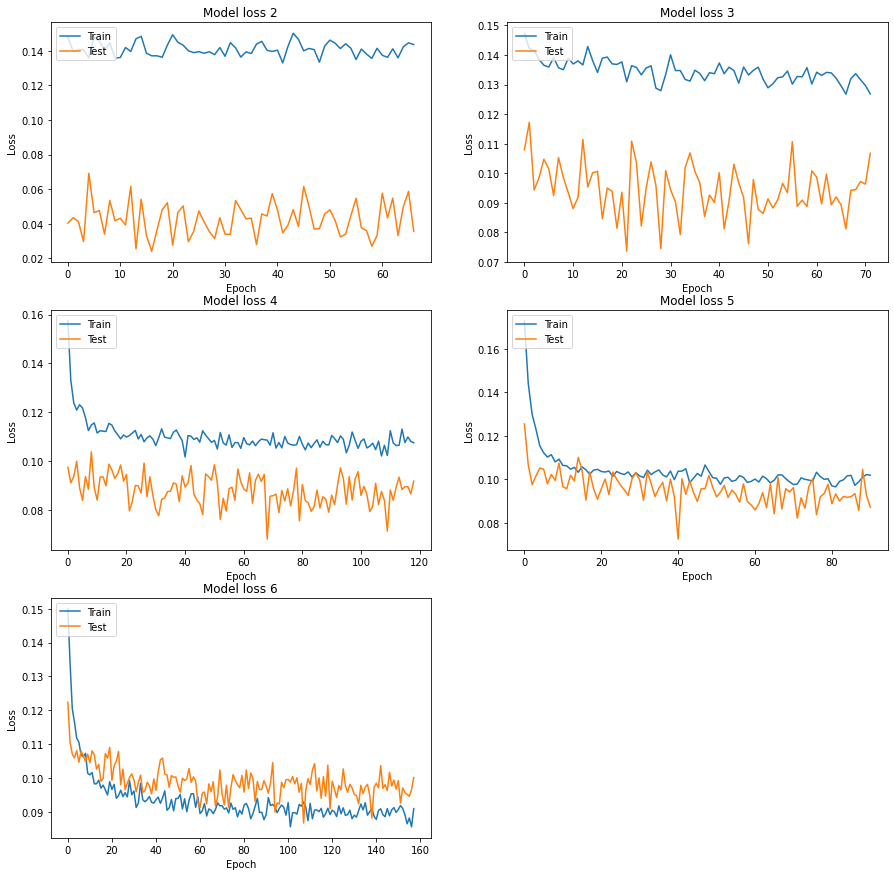

In [12]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history[i+2].history['loss'])
    plt.plot(history[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')